In [1]:
#import
import pandas as pd
import numpy as np
import hddm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pymc
import kabuki
sns.set(style="white")
%matplotlib inline
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

/home/krishn/anaconda3/envs/hddm/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
data = hddm.generate.gen_rl_data_MAB(0.4, num_trials=200, mu=[3.5,2], mu_sd=0.1)

data['rt'] = 0.5
data['subj_idx'] = 111
data['q_init'] = 0
data['split_by'] = 0

data.head()

,trial,response,feedback,rt,subj_idx,q_init,split_by
0,0,1,1.997552,0.5,111,0,0
1,1,1,2.049691,0.5,111,0,0
2,2,1,2.127098,0.5,111,0,0
3,3,0,3.550465,0.5,111,0,0
4,4,0,3.543392,0.5,111,0,0


In [3]:
r0 = data['response'][data['response']==0]
print(len(r0))

130


In [4]:
#run the model by calling hddm.Hrl (instead of hddm.HDDM for normal model and hddm.HDDMrl for rlddm-model)
m_rl = hddm.Hrl(data)

#set sample and burn-in
m_rl.sample(1500,burn=500,dbname='traces.db',db='pickle')
#print stats to get an overview of posterior distribution of estimated parameters
m_rl.print_stats()

 [-----------------100%-----------------] 1500 of 1500 complete in 26.7 sec          mean        std     2.5q    25q       50q      75q     97.5q      mc err
beta  0.432754  0.0939258  0.23089  0.373  0.436221  0.49386  0.611187  0.00299121
DIC: 258.729033
deviance: 257.821697
pD: 0.907336


Parameter estimates from the pure RL-model are a bit different compared to the RLDDM. This is to be expected as probability of choice in DDM is dependent both on the decsision threshold and the scaled difference in q-values, whereas the RL model only uses the scaled difference in q-values. 

Plotting beta


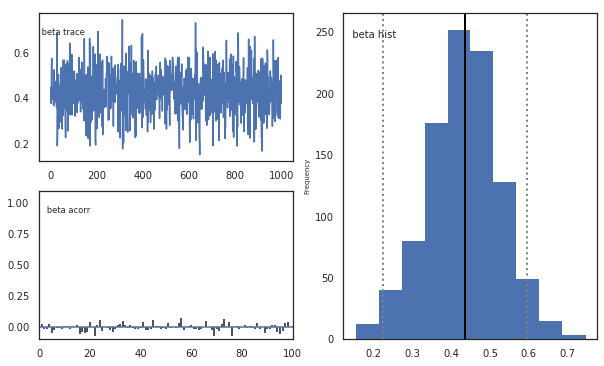

In [5]:
m_rl.plot_posteriors()

In [ ]:
alpha, beta = m_rl.nodes_db.node[['alpha', 'beta']]
samples = {'alpha':alpha.trace(),'beta':beta.trace()}
samp = pd.DataFrame(data=samples)

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(samp, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)